# Sequence composition bias in coding sequences

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#to index the genomic sequence
def symb_ind(symb, sym_num, starts, ends):
    for i in range(len(starts)):
        if(starts[i]<=sym_num<=ends[i]):
            if(symb=='A'):
                return 2
            else:
                return 1     
    if(symb=='A'):
        return 3
    else:
        return 0

In [11]:
#getting start- and end-coordinates from gff-file and defining how much bp take from each cds, and non-cds region
def get_starts_ends_num_bp(fn):
    starts=[]
    ends=[]
    for line in fn:
        line=line.rstrip()
        values=line.split("\t")
        if(values[0][0]!="#"):
            if(values[2]=="CDS"):
                start, end= int(values[3]), int(values[4])
                starts.append(start)
                ends.append(end)
    # the number of bp to take from each cds, and non-cds region equals the mininimum lenght of cds-region 
    len_cds=[]

    for i in range(len(starts)):
        len_cds.append(ends[i]-starts[i])
        
    len_cds=np.array(len_cds)
    num_bp=np.amin(len_cds)
    
    return starts, ends, num_bp

In [4]:
#indexing the genomic sequence
def ind_genome(f, starts, ends):
    sym_num=0
    ind=[]
    for line in f:
        line.rstrip()
        if(line[0]!='>'):
            for i in range(len(line)):
                if(line[i]!='\n'):
                    ind.append(symb_ind(line[i], sym_num, starts, ends))
                    sym_num+=1
    return ind 

In [5]:
#using start- and end-coordinates to calculate 
#the number of times that the nucleotide A appears at a distance k from another nucleotide A in cds-regions
def calc_num_AA_dist_k_cds(ind, num_bp, starts, ends):
    possible_k_cds=np.arange(0,num_bp+1,1)
    num_AA_dist_k_cds=np.zeros(num_bp+1)
    for j in range(len(starts)):
        start_num=int(starts[j])
        for k in range(num_bp+1):
            for i in range(start_num,start_num+num_bp+1,1):
                if(ind[i]==2 and (i+k+1)<=ends[j]):
                    if(ind[i+k+1]==2):
                        num_AA_dist_k_cds[k]+=1
    return num_AA_dist_k_cds, possible_k_cds

In [6]:
#using start- and end-coordinates to calculate 
#the number of times that the nucleotide A appears at a distance k from another nucleotide A in non-cds-regions
def calc_num_AA_dist_k_non_cds(ind, num_bp, starts, ends):
    possible_k_non_cds=np.arange(0,num_bp+1,1)
    num_AA_dist_k_non_cds=np.zeros(num_bp+1)
    a=starts[0]
    for j in range(len(starts)):
        if(starts[j]!=0): #genome-sequence begings from non-cds region
            if(starts[j]==a): #the first non-cds region
                for k in range(num_bp+1):
                    for i in range(0,num_bp+1,1):
                        if(ind[i]==3 and (i+k+1)<=starts[j]-1):
                            if(ind[i+k+1]==3):
                                num_AA_dist_k_non_cds[k]+=1
            elif(j!=len(starts)-1): #middle non-cds region
                start_num=int(ends[j]+1)
                for k in range(num_bp+1):
                    for i in range(start_num,start_num+num_bp+1,1):
                        if(ind[i]==3 and (i+k+1)<=starts[j+1]-1):
                            if(ind[i+k+1]==3):
                                num_AA_dist_k_non_cds[k]+=1
            else: #the last non-cds region
                start_num=int(ends[j]+1)
                if(len(ind)-start_num>=num_bp+1):
                    for k in range(num_bp+1):
                        for i in range(start_num,start_num+num_bp+1,1):
                            if(ind[i]==3 and (i+k+1)<=len(ind)-1):
                                if(ind[i+k+1]==3):
                                    num_AA_dist_k_non_cds[k]+=1
        else: #genome-sequence begings from cds region
            if(j!=len(starts)-1):#all non-cds regions except the last one
                start_num=int(ends[j]+1)
                for k in range(num_bp+1):
                    for i in range(start_num,start_num+num_bp+1,1):
                        if(ind[i]==3 and (i+k+1)<=starts[j+1]-1):
                            if(ind[i+k+1]==3):
                                num_AA_dist_k_non_cds[k]+=1
            else: #the last non-cds region
                start_num=int(ends[j]+1)
                if(len(ind)-start_num>=num_bp+1):
                    for k in range(num_bp+1):
                        for i in range(start_num,start_num+num_bp+1,1):
                            if(ind[i]==3 and (i+k+1)<=len(ind)-1):
                                if(ind[i+k+1]==3):
                                    num_AA_dist_k_non_cds[k]+=1
    return num_AA_dist_k_non_cds, possible_k_non_cds

In [7]:
#constructing the final graph
def make_graph(possible_k_cds,num_AA_dist_k_cds, possible_k_non_cds,num_AA_dist_k_non_cds):
    plt.figure(figsize=(10, 8))
    plt.ylabel('# of A.A at distance k', fontsize=20)
    plt.xlabel('k', fontsize=20)
    plt.plot(possible_k_cds,num_AA_dist_k_cds, '--r', label='cds')
    plt.plot(possible_k_non_cds,num_AA_dist_k_non_cds, '-b', label='non-cds')
    plt.xticks(range(2, max(possible_k_cds)+1, 3))
    plt.legend(loc="upper right")

# Bacillus Anthracis

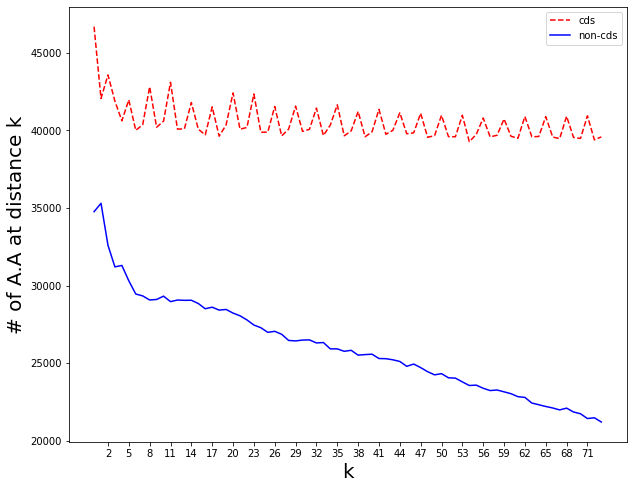

In [8]:
gff=open("Bacillus_Anthracis_genes.txt", "r")
starts, ends, num_bp=get_starts_ends_num_bp(gff)
fna=open("Bacillus_Anthracis.txt", "r")
ind=ind_genome(fna, starts, ends)
num_AA_dist_k_cds, possible_k_cds=calc_num_AA_dist_k_cds(ind, num_bp, starts, ends)
num_AA_dist_k_non_cds, possible_k_non_cds=calc_num_AA_dist_k_non_cds(ind, num_bp, starts, ends)
make_graph(possible_k_cds,num_AA_dist_k_cds, possible_k_non_cds,num_AA_dist_k_non_cds)

# Mycobacterium Tuberculosis

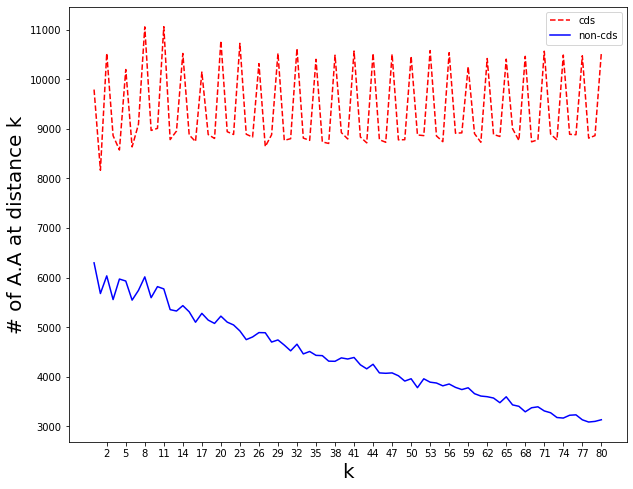

In [9]:
gff=open("Mycobacterium_tuberculosis_genes.txt", "r")
starts, ends, num_bp=get_starts_ends_num_bp(gff)
fna=open("Mycobacterium_tuberculosis.txt", "r")
ind=ind_genome(fna, starts, ends)
num_AA_dist_k_cds, possible_k_cds=calc_num_AA_dist_k_cds(ind, num_bp, starts, ends)
num_AA_dist_k_non_cds, possible_k_non_cds=calc_num_AA_dist_k_non_cds(ind, num_bp, starts, ends)
make_graph(possible_k_cds,num_AA_dist_k_cds, possible_k_non_cds,num_AA_dist_k_non_cds)

# Vibrio Cholerae

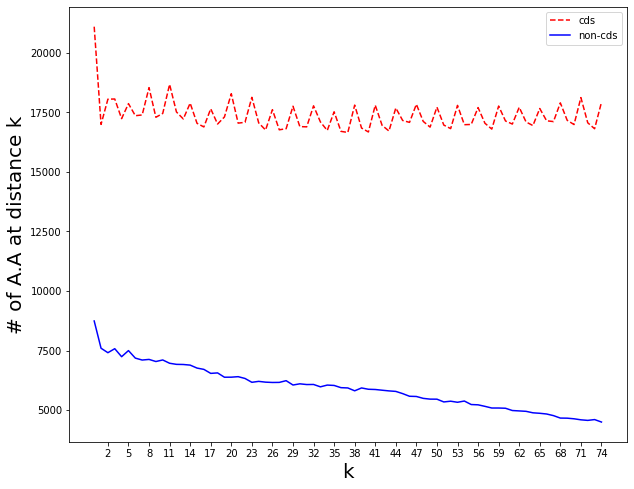

In [10]:
gff=open("Vibrio_cholerae_genes.txt", "r")
starts, ends, num_bp=get_starts_ends_num_bp(gff)
fna=open("Vibrio_cholerae.txt", "r")
ind=ind_genome(fna, starts, ends)
num_AA_dist_k_cds, possible_k_cds=calc_num_AA_dist_k_cds(ind, num_bp, starts, ends)
num_AA_dist_k_non_cds, possible_k_non_cds=calc_num_AA_dist_k_non_cds(ind, num_bp, starts, ends)
make_graph(possible_k_cds,num_AA_dist_k_cds, possible_k_non_cds,num_AA_dist_k_non_cds)

# Streptococcus Pneumoniae

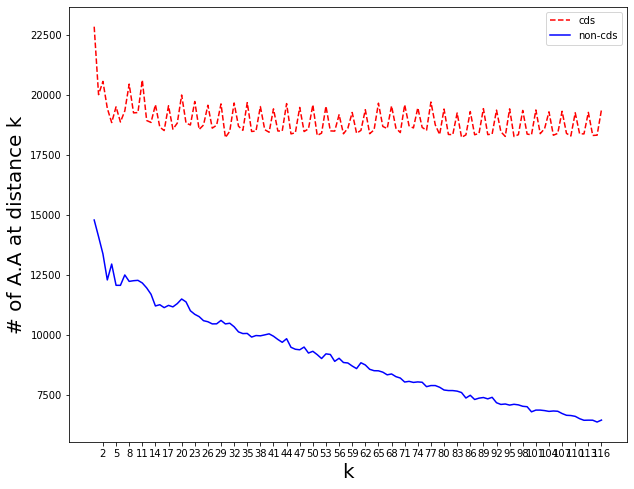

In [11]:
gff=open("Streptococcus_pneumoniae_genes.txt", "r")
starts, ends, num_bp=get_starts_ends_num_bp(gff)
fna=open("Streptococcus_pneumoniae.txt", "r")
ind=ind_genome(fna, starts, ends)
num_AA_dist_k_cds, possible_k_cds=calc_num_AA_dist_k_cds(ind, num_bp, starts, ends)
num_AA_dist_k_non_cds, possible_k_non_cds=calc_num_AA_dist_k_non_cds(ind, num_bp, starts, ends)
make_graph(possible_k_cds,num_AA_dist_k_cds, possible_k_non_cds,num_AA_dist_k_non_cds)